# Images

This tutorial will show how to load, manipulate and display images, using opencv, numpy and matplotlib.

We'll first import the libraries we'll use in this tutorial:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 

## Loading and displaying images

We'll first start off by loading an image, and looking at what result we get. For this we'll use opencv's `imread` function.

In [2]:
image = cv2.imread("car.jpg")
print("Image shape", image.shape)
print("Image datatype", image.dtype)

Image shape (512, 512, 3)
Image datatype uint8


We notice that the image is a 512x512x3 numpy array, and it's datatype is `uint8`.

This image is a 512x512 RGB image, and each pixel consists of 3 8-bit unsigned integer values. These contain the red, green and blue colour channels of the image. Since they are 8-bit values, they can contain integer values from 0 to 255 only.

The array has 3 dimensions, which contain the 512 rows, 512 columns and 3 channels of the image, giving the shape (512, 512, 3) above.

If we want to display this image, we can use matplotlib's `imshow` function.

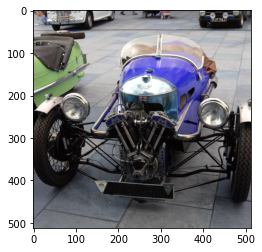

In [3]:
plt.imshow(image)
plt.show()

Right away there is a bit of an issue. This car is really red, but when we displayed it above it was blue. This is because opencv loads images in BGR format by default. However, `imshow` in matplotlib expects RGB input. We can convert it simply by changing the order of the channels, but alternatively opencv has a built in function `cvtColor` for converting colours.

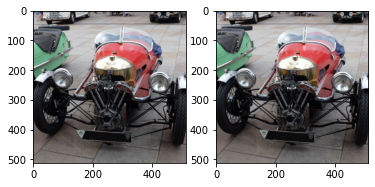

In [4]:
# Manually reversing the order of the channels.
image_rgb = np.zeros_like(image)
image_rgb[:,:,0] = image[:,:,2]
image_rgb[:,:,1] = image[:,:,1]
image_rgb[:,:,2] = image[:,:,0]

plt.subplot(1,2,1)
plt.imshow(image_rgb)

# Using opencv's built-in colour conversion function.
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplot(1,2,2)
plt.imshow(image_rgb)
plt.show()

This function `cvtColor` can convert to a wide range of different colourspaces, and is useful for a wide range of applications:

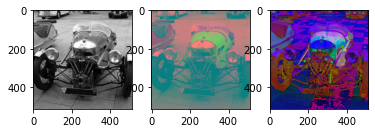

In [5]:
# Converting to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.subplot(1,3,1)
plt.imshow(image_gray, cmap="gray", vmin=0, vmax=255) #Note we have to set the colourmap to "gray" and the min and max values here.

# Converting to YCrCb (Decorrelated colourspace with Y intensity, Cb and Cr chroma channels)
image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
plt.subplot(1,3,2)
plt.imshow(image_ycrcb)

# Converting to HSV (hue, saturation, value)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.subplot(1,3,3)
plt.imshow(image_hsv)

Note that when showing the grayscale image above, we had to set `cmap="gray"` and `vmin=0, vmax=255`.

This is because by default, when given 2D input, `imshow` will show a false-colour image:

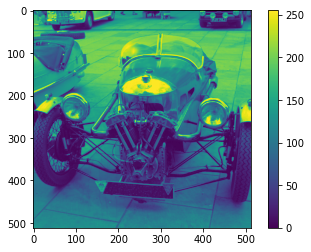

In [6]:
plt.imshow(image_gray)
plt.colorbar() # Shows a colorbar, indicating what each false color corresponds to.
plt.show()

This can be useful for displaying error maps and the like, but it's important to remember this when you just want to display greyscale images.

## Image datatypes

The image we just loaded is in RGB888 format, with each pixel value stored as 3 8-bit unsigned integer values.

This is compact, which is useful when saving images to disk. However, when manipulating images they often don't work well, causing loss of precision or overflow.

For this reason we often convert to a floating-point format before working on images.

When an image is in a format like float32, the values are normally rescaled to lie in the range [0,1]. We do this by dividing by 255 as below:

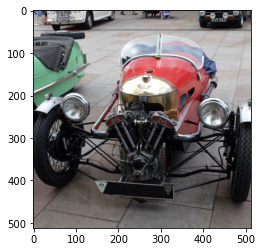

In [7]:
image_float = image_rgb.astype(np.float32) / 255. 
# image_float now contains 32-bit floating-point values in the range [0,1].
# Functions like imshow() will work with this as normal:
plt.imshow(image_float)
plt.show()

## Denoising example

Opencv and numpy contain a wide range of functions for image manipulation and computer vision. 

To show how they can be used, and how matplotlib can be used to plot and visualise the results, we'll run through a quick example of a common image processing task: Denoising.

We'll start off by adding some noise to our image, to get an input we can denoise.

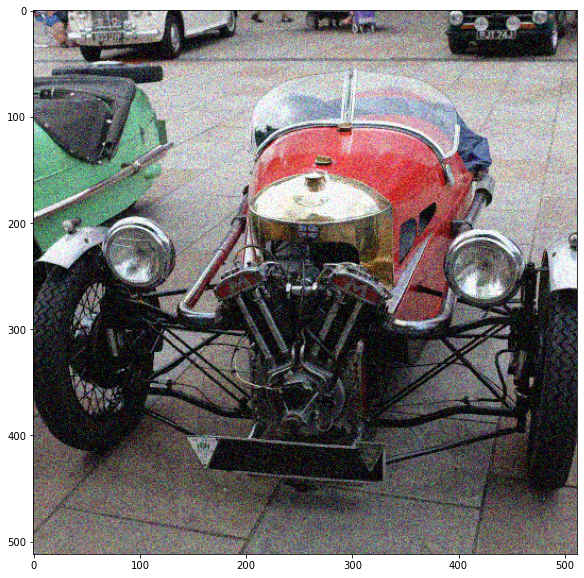

In [8]:
noisy_image = image_float + np.random.normal(scale=0.10, size=image.shape).astype(np.float32) # Add gaussian noise of stdev 0.1
noisy_image[noisy_image > 1.0] = 1.0 # Set any values above 1.0 to 1.0
noisy_image[noisy_image < 0.0] = 0.0 # Set any values below 0.0 to 0.0
# Now we have a noisy image in the range [0, 1]

plt.figure(figsize=[10,10]) # Make figure bigger so noise is visible
plt.imshow(noisy_image)
plt.show()

We'll try denoising this with a [bilateral filter](https://users.soe.ucsc.edu/~manduchi/Papers/ICCV98.pdf). This is a common image filter which tries to blur in a conservative way, avoiding destroying strong edges in the input.

float32


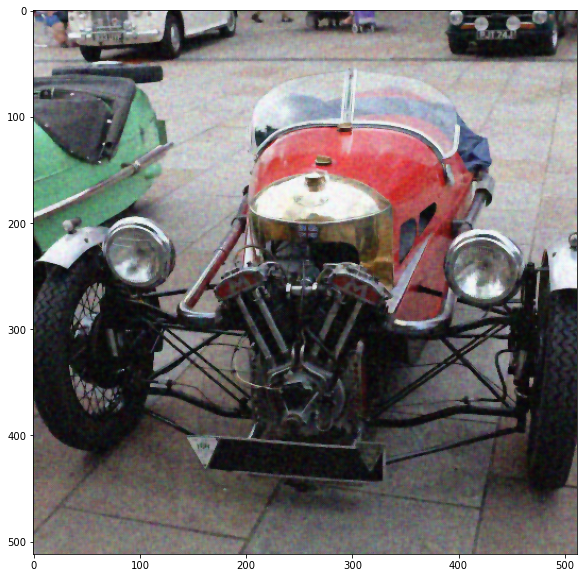

In [9]:
print(noisy_image.dtype)
denoised_image = cv2.bilateralFilter(noisy_image, d=5, sigmaColor=0.5, sigmaSpace=3.0)

plt.figure(figsize=[10,10])
plt.imshow(denoised_image)
plt.show()

That seems less noisy. We can try to get a better idea of how well it worked by plotting an error map.

We'll do this by measuring the difference at each pixel in colour space, giving us a 512x512 array. We can then show a false colour plot of this using `plt.imshow()`.

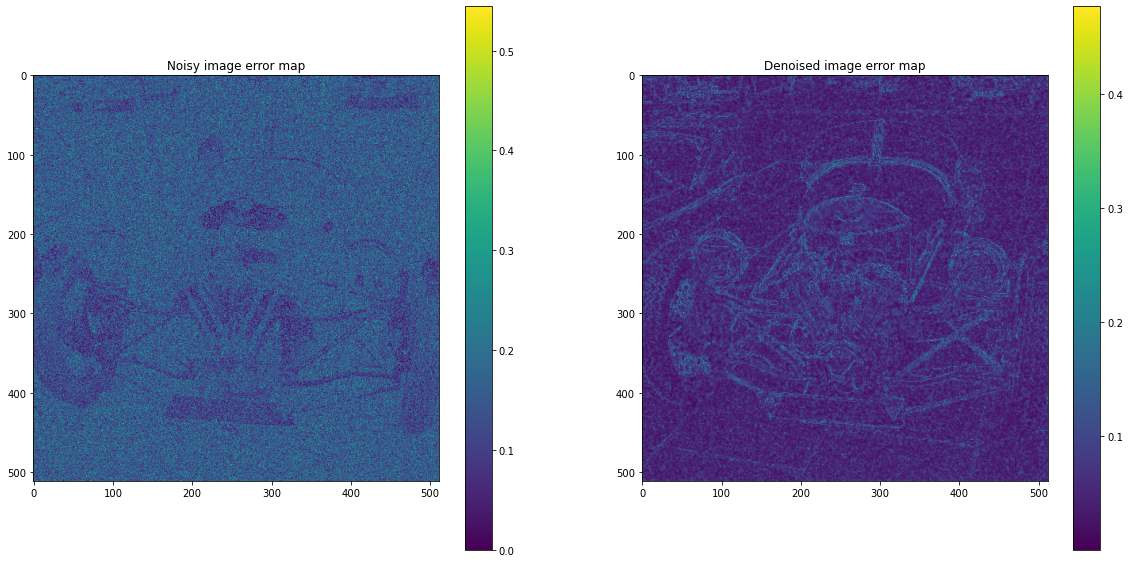

In [10]:
def make_error_map(image, gt_image):
    sq_diff = 0
    for c in range(3):
        diff = image[...,c] - gt_image[...,c]
        sq_diff += diff * diff
    return np.sqrt(sq_diff)

# Make error map for noisy image
noisy_errmap = make_error_map(noisy_image, image_float)

# Make error map for denoised image
denoised_errmap = make_error_map(denoised_image, image_float)

plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
plt.title("Noisy image error map")
plt.imshow(noisy_errmap)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Denoised image error map")
plt.imshow(denoised_errmap)
plt.colorbar()

plt.show()

From this error map it's clear to see that the denoised image has less error overall, and we can also see that the error that remains is concentrated at strong edges in the image.

This may mean that the parameters of the bilateral filter could be adjusted to better preserve the edges and get an improved result.

If we want to quantify how much the denoising has helped, we could use a metric like Mean Squared Error (MSE):

In [11]:
def mean_squared_error(image, gt_image):
    diff = image - gt_image
    return np.mean(diff * diff)

print("MSE of noisy image", mean_squared_error(noisy_image, image_float))
print("MSE of denoised image", mean_squared_error(denoised_image, image_float))

MSE of noisy image 0.008920793
MSE of denoised image 0.0017038995


As we can see, the MSE of the denoised image is substantially lower. 

Now we might want to save our denoised image. Before saving, there are a couple of things to do.

First, as mentioned above OpenCV expects images in BGR format. To convert it back we use `cvtColor` as before:

In [12]:
denoised_image_bgr = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2BGR)

Finally we want to convert it to 8-bit unsigned integer format again, so we can save it as a PNG image.

Note that there are other image formats like EXR that can store floating-point values if you need this, but they take up more space, and the extra precision can't be seen on regular LDR displays. OpenCV can read and write EXR files (but you may need to change the parameters to get best results).

In [13]:
# Convert to 8-bit unsigned integer. Note we need to multiply by 255, as 8-bit images 
# are in the [0,255] range.
denoised_image_bgr_8 = (denoised_image_bgr * 255).astype(np.uint8)

# Now we can save the image to a file using imwrite:
cv2.imwrite("output/car_denoised.png", denoised_image_bgr_8)

# Note that cv2.imwrite is "smart" and will automatically change the file format according to
# the extension you provide.
# To save as JPEG for example, just provide a filename ending in ".jpg".

True

## More on Colourspaces

We converted some images to the colourspaces YCbCr and HSV above, but did not discuss them in detail. Here we'll explain more what YCbCr in particular is, and why it's useful.

First let's cover some basics on RGB. As you probably know, we use RGB image encoding and displays because most humans have 3 types of colour-sensitive cells in their retinas. These 3 types respond mostly to red, green and blue light respectively. 

For this reason, even though light is really a power spectrum, to display all the colours a human can perceive, it's enough to combine light of just 3 different wavelengths; red, green and blue.

We've called RGB a colourspace, and it really is a space - we can picture it as a cube [0,1]^3 where each point in the cube has a unique colour. Let's try plotting this cube in matplotlib.

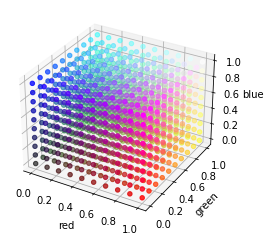

In [14]:
import matplotlib.pyplot as plt
import numpy as np

reds = np.linspace(0, 1, num=10)
greens = np.linspace(0, 1, num=10)
blues = np.linspace(0, 1, num=10)

# Meshgrid works in 3D too! This will give us an x, y and z value for every point in the 10x10x10 grid within the cube.
reds, greens, blues = np.meshgrid(reds, greens, blues) 

# However, meshgrid will return 10x10x10 arrays, so we'll flatten them.
reds = reds.flatten()
greens = greens.flatten()
blues = blues.flatten()

# We'll make an array of colours to give to the plotting function.
colours = np.array([[r, g, b] for r, g, b in zip(reds, greens, blues)])

ax = plt.axes(projection="3d")
ax.set_xlabel("red")
ax.set_ylabel("green")
ax.set_zlabel("blue")

# We use scatter in 3D here, and supply a colour for each dot with c=colours.
ax.scatter(reds, greens, blues, c=colours)

This looks the way we might expect, with 0,0,0 being black, and 1,1,1 being white. At the other corners of the cube we have red, green, blue, cyan, magenta and yellow.

YCbCr is quite a different colourspace. In YCbCr, the Y channel contains intensity, the brightness of the colour. The Cb and Cr channels contain colour information.

I'll plot another graph, but this time I'll first convert the colours array to show what the YCrCb colourspace looks like. Because matplotlib expects RGB colours, I'll first make the RGB cube as before, then convert it to YCrCb. I'll then plot using the YCrCb coordinates, but show the RGB values. I'm using the same conversion formula as `opencv`'s `cvtColor` function (see the documentation [here](https://docs.opencv.org/4.5.3/de/d25/imgproc_color_conversions.html))

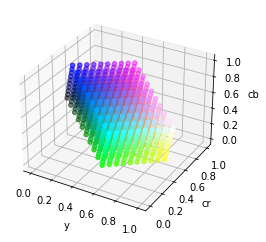

In [15]:
def rgb2ycrcb(rgb):
    y = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    cr = (rgb[0]-y)*0.713 + 0.5
    cb = (rgb[2]-y)*0.564 + 0.5
    return np.array([y, cr, cb])

reds = np.linspace(0, 1, num=10)
greens = np.linspace(0, 1, num=10)
blues = np.linspace(0, 1, num=10)

# Make an x, y and z value for every point in the 10x10x10 grid within the cube.
reds, greens, blues = np.meshgrid(reds, greens, blues) 

# Flatten them to get long 1D arrays of length 10x10x10 = 1000
reds = reds.flatten()
greens = greens.flatten()
blues = blues.flatten()

# We'll make an array of colours in rgb and ycrcb to give to the plotting function.
colours_rgb = np.array([[r, g, b] for r, g, b in zip(reds, greens, blues)])
colours_ycrcb = np.array([rgb2ycrcb(colours_rgb[i,:]) for i in range(colours_rgb.shape[0])])

ys = colours_ycrcb[:,0]
crs = colours_ycrcb[:,1]
cbs = colours_ycrcb[:,2]

ax = plt.axes(projection="3d")
ax.set_xlabel("y")
ax.set_ylabel("cr")
ax.set_zlabel("cb")

# We use scatter in 3D here, and supply a colour for each dot with c=colours.
ax.scatter(ys, crs, cbs, c=colours_rgb)

Notice that the shape of the result is no longer a cube; it has been warped by something similar to a linear transformation (but not a true linear transformation as it isn't centred around zero).

Since Y contains intensity, as we might expect, at the point where Y is 0, the colour is black. Where it is 1, the colour is white.

Where Cb and Cr are equal to 0.5, the colours are shades of grey, but as they move away from this centre line they become more colourful.

You might have noticed something strange about how we generated the Y channel above. We didn't weight R, G and B equally as you might expect. Instead, we weighted G more than R, and R more than B. This is because YCrCb is a perceptual colourspace - it tries to ensure that the intensity corresponds to the intensity a human would perceive. That is, if we pick two different colours with the same Y value, they should look equally bright.

Humans are more sensitive to green light than red, and more sensitive to red light than blue, so weighting the channels in this way makes sense.

Let's test this. We'll construct a 2D image consisting of all colours where Y is 0.5 - effectively a 2D slice through the shape above.

Note that we have to be a bit careful doing this - not all points in the [0,1]^3 cube for YCrCb will convert back to valid RGB values. For example, [0,0,0] doesn't fall inside the distorted cube above. We'll set these invalid pixels to 0.

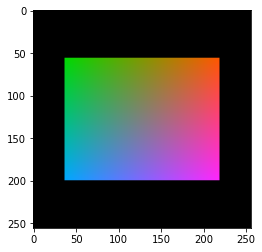

In [16]:
# This is just the inverse of rgb2ycrcb above - you can check this if you want, by 
# doing some simultaneous equations.
def ycrcb2rgb(ycrcb):
    r = ycrcb[0] + 1.403*(ycrcb[1] - 0.5)
    g = ycrcb[0] - 0.714*(ycrcb[1] - 0.5) - 0.344*(ycrcb[2] - 0.5)
    b = ycrcb[0] + 1.773*(ycrcb[2] - 0.5)

    # Check that none of the values are outside the valid range [0, 1]
    # If they are, return [0, 0, 0].
    if any([i < 0 for i in [r, g, b]]) or any([i > 1 for i in [r, g, b]]):
        return [0,0,0]

    # No invalid values, so return the RGB colour.
    return np.array([r, g, b])

# Make 2D maps of all Cr and Cb values in the [0, 1] range.
crs = np.linspace(0, 1, num=256)
cbs = np.linspace(0, 1, num=256)
crs, cbs = np.meshgrid(crs, cbs)

# Try changing this! For any value, all the colours should look equally bright.
# Note that the shape of the cross-section changes for different values of y.
# At y = 1 you'll get a black image as only one infinitely small point in the space is valid.
y = 0.5

image = np.zeros([256, 256, 3])

for row in range(256):
    for col in range(256):
        image[row, col, :] = ycrcb2rgb([y, crs[row, col], cbs[row, col]])

plt.imshow(image)
plt.show()

This is interesting, but one thing you might ask is "what can we do with this?". 

One thing that colourspaces like this are used for is image compression. A version of YCrCb is used in the JPEG compression standard for this reason.

On the whole, we're more sensitive to differences in intensity than differences in colour. Because of this one really simple way to compress an image is to store the Cr and Cb channels at lower resolution than Y. This is known as [Chroma Subsampling](https://en.wikipedia.org/wiki/Chroma_subsampling). 

Let's try this on the "Car" image and see how it affects the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Downsampled chroma size: (256, 256, 2)
Compression ratio: 0.5
Downsampled chroma size: (64, 64, 2)
Compression ratio: 0.34375
Downsampled chroma size: (16, 16, 2)
Compression ratio: 0.333984375


True

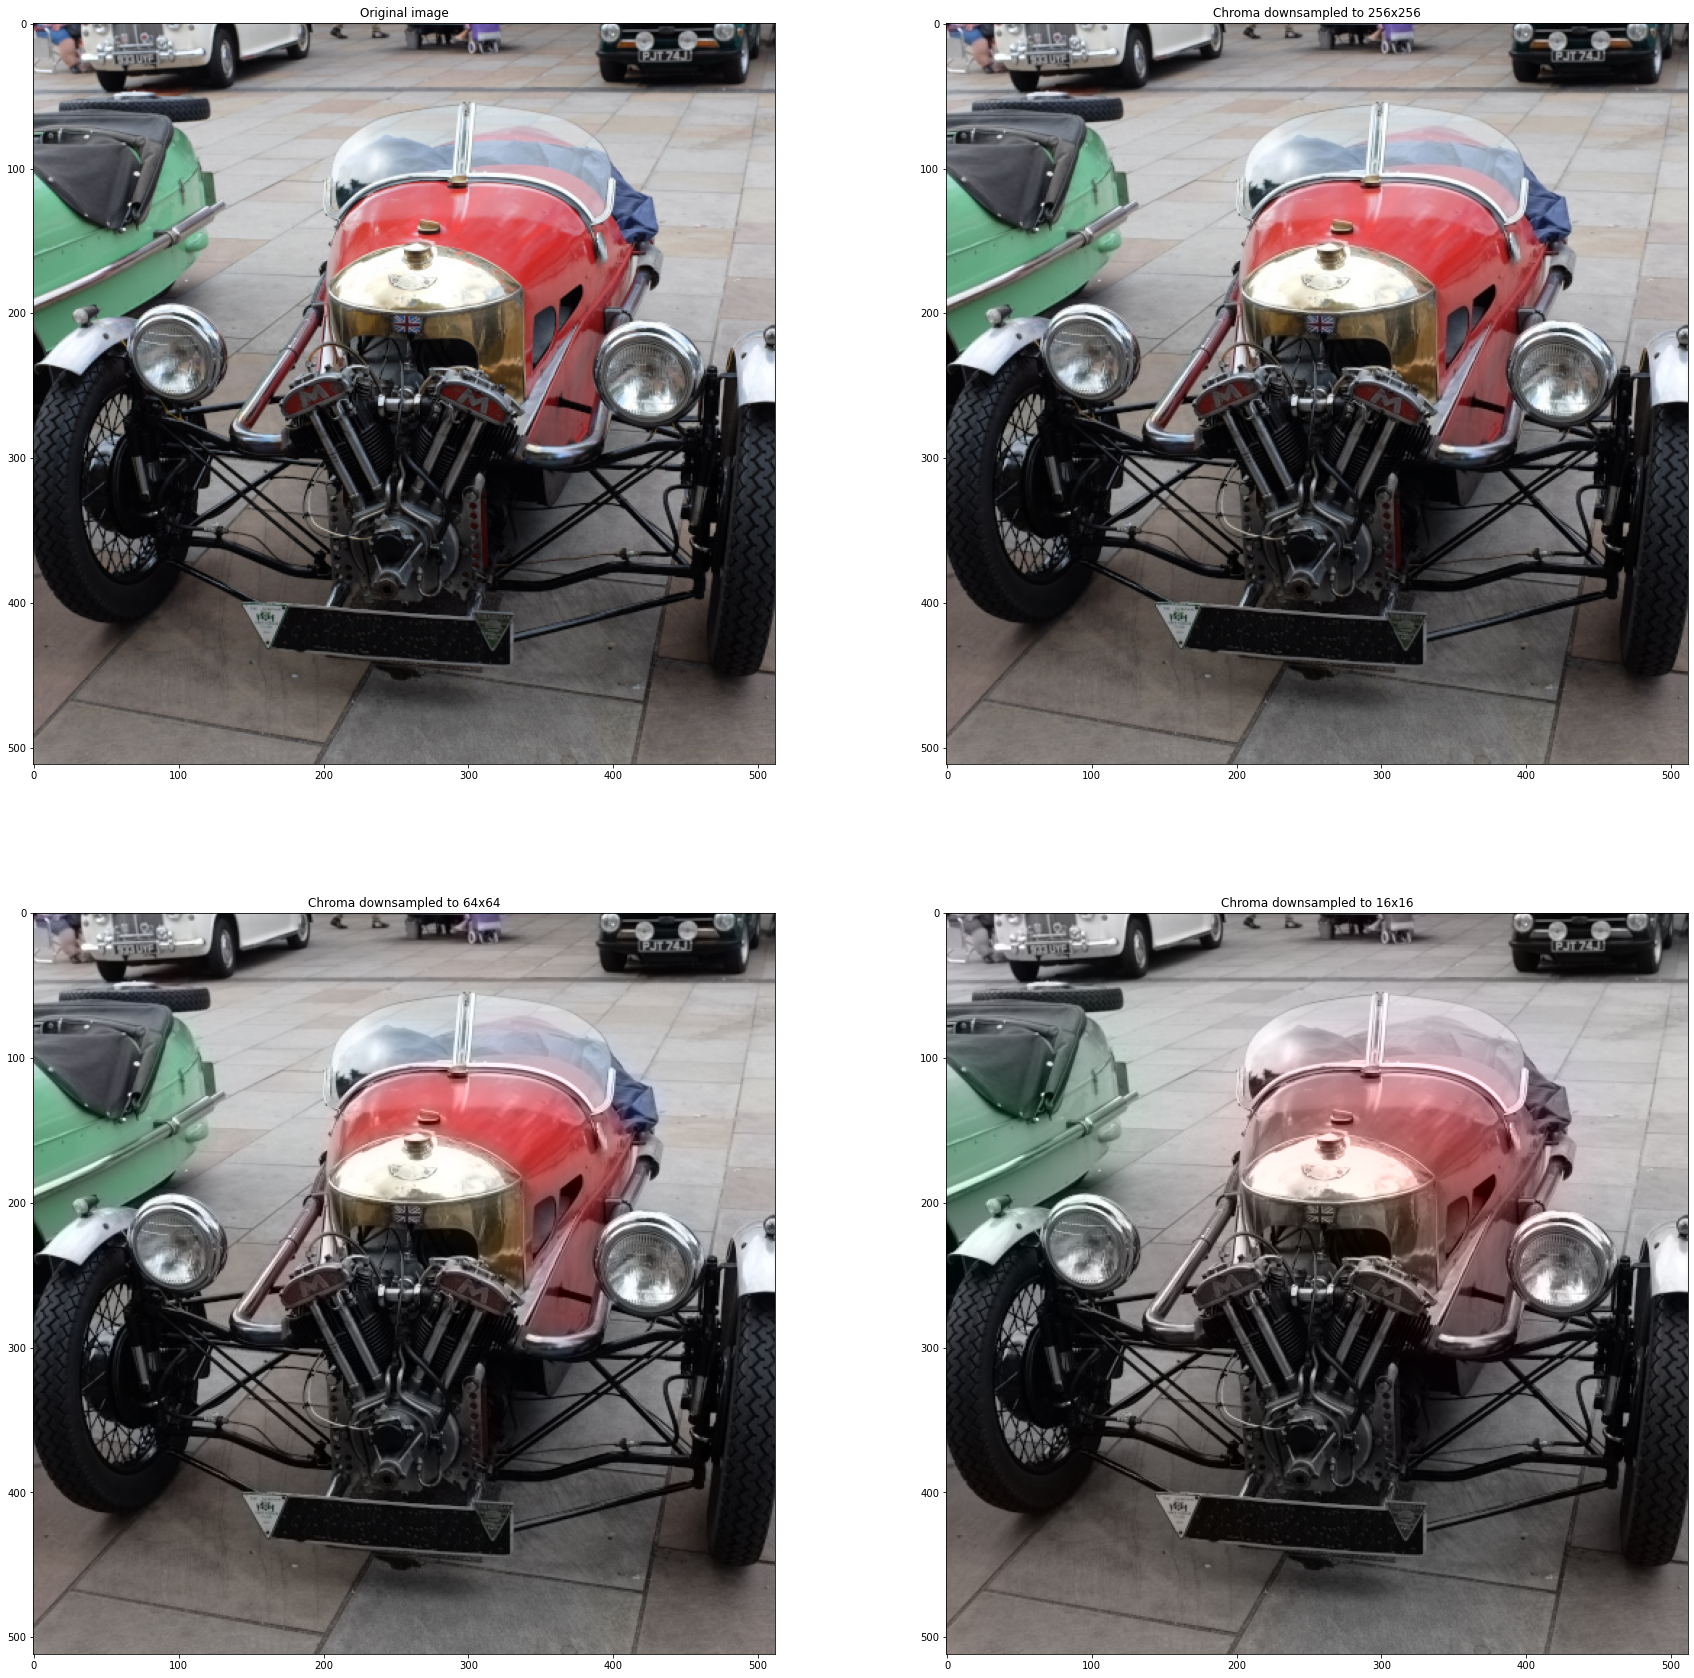

In [17]:
import cv2

def simulate_chroma_subsampling(image, times_to_downsample):
    # This downsamples an image 2x in each dimension (so it's 1/4 the pixel count) a number of times, and then upsamples again.
    # This simulates the effect of storing the image at a lower resolution.
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    # Count number of elements in the input, so we can work out the compression ratio later.
    input_num_elements = image.size

    crcb = ycrcb_image[:,:,1:]

    for i in range(times_to_downsample):
        # This built-in opencv function downsamples 2x in each dimension, in a sensible way.
        crcb = cv2.pyrDown(crcb)

    print("Downsampled chroma size:", crcb.shape)

    # Save number of elements for later
    crcb_size = crcb.size

    for i in range(times_to_downsample):
        # ... and this one upsamples again:
        crcb = cv2.pyrUp(crcb)

    ycrcb_image[:,:,1:] = crcb

    image = cv2.cvtColor(ycrcb_image, cv2.COLOR_YCrCb2RGB)

    # Work out number of elements in compressed image
    compressed_num_elements = crcb_size + ycrcb_image[:,:,0].size

    # Work out & print the compression ratio
    compression_ratio = float(compressed_num_elements) / float(input_num_elements)
    print("Compression ratio:", compression_ratio)

    return image

# Here we load, convert to RGB, convert to float and divide by 255 all in one line.
# Now we've got a floating-point RGB image in [0,1] range.
image = cv2.cvtColor(cv2.imread("car.jpg"), cv2.COLOR_BGR2RGB).astype(np.float32) / 255

compressed_image_2x = simulate_chroma_subsampling(image, 1)
compressed_image_8x = simulate_chroma_subsampling(image, 3)
compressed_image_32x = simulate_chroma_subsampling(image, 5)

plt.figure(figsize=(30,30))
plt.subplot(2,2,1)
plt.imshow(image)
plt.title("Original image")
plt.subplot(2,2,2)
plt.imshow(compressed_image_2x)
plt.title("Chroma downsampled to 256x256")
plt.subplot(2,2,3)
plt.imshow(compressed_image_8x)
plt.title("Chroma downsampled to 64x64")
plt.subplot(2,2,4)
plt.imshow(compressed_image_32x)
plt.title("Chroma downsampled to 16x16")

# Save the results to disk.
# Note that cv2.imwrite wants BGR input in the range [0, 255] so we have to do a bit of conversion.
cv2.imwrite("output/chroma_subsampled_car_2x.png", cv2.cvtColor(compressed_image_2x, cv2.COLOR_RGB2BGR)*255)
cv2.imwrite("output/chroma_subsampled_car_8x.png", cv2.cvtColor(compressed_image_8x, cv2.COLOR_RGB2BGR)*255)
cv2.imwrite("output/chroma_subsampled_car_32x.png", cv2.cvtColor(compressed_image_32x, cv2.COLOR_RGB2BGR)*255)

As you can see, chroma subsampling is a simple but very effective way of compressing an image, and the chroma can be downsampled to a surprisingly low resolution without greatly affecting the result. The image is only severely affected when the chroma is downsampled to 16x16 pixels. The above code saves the results to files, so you can open them in an image editor and zoom in if you would like to.

Chroma subsampling is a widely used technique - one example of its use was in [porting Resident Evil 2 from Playstation to N64](https://www.eurogamer.net/articles/digitalfoundry-2018-retro-why-resident-evil-2-n64-is-one-of-the-most-ambitious-ports-of-all-time). This required reducing the size of the game files to fit on a single 64MB cartridge rather than two 700MB CDs, and applying chroma subsampling to the video files in the game was a key part of this.